In [30]:
using Plots;
gadfly();

### Load FDTD Libraries

In [31]:
include("../fdtd/update.jl");
include("../fdtd/sources.jl");
include("../fdtd/boundaries.jl");
using update;
using sources;

# 0. Vacuum with trivial ABC ez[-1] = ez[-2]
### Setup Grid

In [66]:
#Global parameters
size = 200
endTime = 400
num_snaps = 200
snap_step = div(endTime, num_snaps)
#Grid
hy = zeros(size);
ez = zeros(size);
# output params
ez_snapshot = Array{Any}(num_snaps);
hy_snapshot = Array{Any}(num_snaps);

fieldsum = 1;
sumtime = 250;
fieldsnap = zeros(size);

### Run simulation

In [67]:
#Time steps

for time in 1:endTime
    # TFSF Boundary at center
    ez_inc, hy_inc = sources.gaussian_source(200, time, 70)  
    
    #
    # Magnetic
    #
    
    # Boundary, Trivial ABC
    boundaries.trivial_abc!(hy, 200)

    # Update
    update.update_magnetic_field!(ez, hy)
    
    # TFSF
    hy[div(length(ez),2)-1] -= hy_inc
    
    #
    # Electric
    #
    
    # Update
    update.update_electric_field!(ez, hy)
    
    # TFSF
    ez[div(length(ez),2)] += ez_inc
    
    # Boundary, PEC
    boundaries.perfect_conductor!(ez, 1)
    
    
    #Catch minimum E-Field
    if time == sumtime
            fieldsum = sum(ez.^2)
            fieldsnap = copy(ez)
    end
    
    #Snapshots for animation
    if mod(time, snap_step) == 0
        ez_snapshot[div(time,snap_step)] = (time, copy(ez))
        hy_snapshot[div(time,snap_step)] = (time, copy(hy).*globals.imp0)        
    end
    
end
print(fieldsum)

1.9542144317996692e-31

### Plot

In [68]:
anim = Animation()

for i = 1:num_snaps
    p = plot(1:size, ez_snapshot[i][2], lab="Ez")
    plot!(1:size, hy_snapshot[i][2], lab="Hy*imp0")
    
    time = ez_snapshot[i][1]
    plot!(ann=[(150, 1.5, "time =$time")])
    plot!(ann=[(0, 1.1, "PEC")])
    plot!(ann=[(180, 1.1, "ABC")])    
    plot!(xlims=(1, 200), ylims=(-2, 2))
    frame(anim, p)
end
gif(anim, "./Task1/PEC-ABC.gif", fps=15)

INFO: Saved animation to /media/storage/Documents/Github/1d-fdtd/tasks/Task1/PEC-ABC.gif


Plots.AnimatedGif("/media/storage/Documents/Github/1d-fdtd/tasks/Task1/PEC-ABC.gif")

### Plot field after reflection

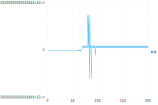

In [35]:
plot(1:size, fieldsnap)

In [36]:
print(fieldsum)

1.9542144317996692e-31

# 1. Dielectric eps=9 with trivial ABC ez[-1] = ez[-2]
### Setup Grid

In [63]:
#Global parameters
size = 200;
endTime = 1000;
num_snaps = 200;
snap_step = div(endTime, num_snaps);
#Grid
hy = zeros(size-1);
mu = ones(size-1);

ez = zeros(size);
eps = ones(size);

for i in 100:size
    eps[i] = 9
end

# output params
ez_snapshot = Array{Any}(num_snaps);
hy_snapshot = Array{Any}(num_snaps);

# 
fieldsum = 1;
sumtime = 650;
fieldsnap = zeros(size);

### Run Simulation

In [64]:
# Time steps

for time in 1:endTime
    delay = 250.
    width = 400.
    
    ez_inc, hy_inc = sources.gaussian_source(50, time, delay, width)  
    
    #
    # Magnetic
    #
        
    # Interior update
    update.update_magnetic_field!(ez, hy, mu);    
    
    # TFSF
    hy[49] -= hy_inc 
    
    #
    # Electric
    #
    
    # ABC
    boundaries.trivial_abc!(ez, size);
    boundaries.trivial_abc!(ez, 1, false);    
    
    # Interior update
    update.update_electric_field!(ez, hy, eps);
    
    # TFSF
    ez[50] += ez_inc 
 
    #Catch minimum E-Field
    if time == sumtime
            fieldsum = sum(ez.^2)
            fieldsnap = copy(ez)
    end
    
    #Snapshots for animation
    if mod(time, snap_step) == 0
        ez_snapshot[div(time,snap_step)] = (time, copy(ez))
        hy_snapshot[div(time,snap_step)] = (time, copy(hy).*globals.imp0)        
    end
    
end
print(fieldsum)

0.523525041519659

### Plot Animation

In [39]:
anim = Animation()

for i = 1:num_snaps
    p = plot(1:size, ez_snapshot[i][2], lab="Ez")
    plot!(1:size-1, hy_snapshot[i][2], lab="Hy*imp0")
    
    time = ez_snapshot[i][1]
    plot!(ann=[(150, 1.5, "time =$time")])
    plot!(ann=[(0, 1.1, "ABC")])
    plot!(ann=[(180, 1.1, "ABC")])
    
    plot!(ann=[(80, 1.2, "Eps = 1")])
    plot!(ann=[(100, 1.1, "Eps = 9")])    
    plot!([100, 100], [-2, 2])
    
    plot!(xlims=(1, 200), ylims=(-2, 2))
    frame(anim, p)
end
gif(anim, "./Task1/ABC-Bad-Trivial-ABC.gif", fps=15)

INFO: Saved animation to /media/storage/Documents/Github/1d-fdtd/tasks/Task1/ABC-Bad-Trivial-ABC.gif


Plots.AnimatedGif("/media/storage/Documents/Github/1d-fdtd/tasks/Task1/ABC-Bad-Trivial-ABC.gif")

### Plot field after reflection

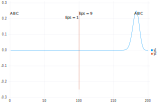

In [65]:
plot(1:size, fieldsnap)
plot!([100, 100], [-maximum(abs(fieldsnap)), maximum(abs(fieldsnap))])
plot!(ann=[(80, 0.8*maximum(abs(fieldsnap)), "Eps = 1")])
plot!(ann=[(100, 0.9*maximum(abs(fieldsnap)), "Eps = 9")])
plot!(ann=[(0, 0.9*maximum(abs(fieldsnap)), "ABC")])
plot!(ann=[(180, 0.9*maximum(abs(fieldsnap)), "ABC")])

In [41]:
print(fieldsum)

0.37112237808209564

# 2. Dielectric eps=9 with Mur ABC
### Setup Grid

In [59]:
#Global parameters
size = 200;
endTime = 1000;
num_snaps = 200;
snap_step = div(endTime, num_snaps);

eps1 = 9;
eps0 = 1;

#Grid

# Magnetic
hy = zeros(size-1);
mu = ones(size-1);

chyh = ones(size);
chye = ones(size);


# Electric
ez = zeros(size);
eps = ones(size);

cezh = ones(size);
ceze = ones(size);


for i in 1:99
    eps[i] = eps0;
end
for i in 100:size
    eps[i] = eps1;
end

rightBound = boundaries.setup_first_order_abc(eps, mu, size, true)
leftBound = boundaries.setup_first_order_abc(eps, mu, 1, false)

# output params
ez_snapshot = Array{Any}(num_snaps);
hy_snapshot = Array{Any}(num_snaps);

# 
fieldsum = 1;
sumtime = 650;
fieldsnap = zeros(size);

### Run simulation

In [60]:
# Time steps

for time in 1:endTime
    # Incident
    # ez_inc, hy_inc = sources.gaussian_source(50, time);
    delay = 250.
    width = 400.
    
    ez_inc = exp(-(time + 0.5 - (-0.5) - delay) * (time + 0.5 - (-0.5) - delay) / width);
    hy_inc = exp(-(time - delay) * (time - delay) / width) / globals.imp0;
    
    #
    # Magnetic
    #
        
    # Interior update
    update.update_magnetic_field!(ez, hy, mu, chyh, chye);    
    
    # TFSF
    hy[49] -= hy_inc 
    
    #
    # Electric
    #
       
    # Interior update
    update.update_electric_field!(ez, hy, eps, cezh, ceze);
    
    # ABC
    boundaries.first_order_diff_abc!(ez, leftBound)
    boundaries.first_order_diff_abc!(ez, rightBound)
    
    # TFSF
    ez[50] += ez_inc 
 
    #Catch minimum E-Field
    if time == sumtime
            fieldsum = sum(ez.^2)
            fieldsnap = copy(ez)
    end
    
    #Snapshots for animation
    if mod(time, snap_step) == 0
        ez_snapshot[div(time,snap_step)] = (time, copy(ez))
        hy_snapshot[div(time,snap_step)] = (time, copy(hy).*globals.imp0)        
    end
    
end
print(fieldsum)

1.0022636888954596e-5

### Plot animation

In [62]:
anim = Animation()

for i = 1:num_snaps
    p = plot(1:size, ez_snapshot[i][2], lab="Ez")
    plot!(1:size-1, hy_snapshot[i][2], lab="Hy*imp0")
    
    time = ez_snapshot[i][1]
    plot!(ann=[(150, 1.5, "time =$time")])
    plot!(ann=[(0, 1.1, "ABC")])
    plot!(ann=[(180, 1.1, "ABC")])
    
    plot!(ann=[(80, 1.2, "Eps = 1")])
    plot!(ann=[(100, 1.1, "Eps = 9")])    
    plot!([100, 100], [-2, 2])
    
    plot!(xlims=(1, 200), ylims=(-2, 2))
    frame(anim, p)
end
gif(anim, "./Task1/Mur-ABC-Mur-ABC.gif", fps=15)

INFO: Saved animation to /media/storage/Documents/Github/1d-fdtd/tasks/Task1/Mur-ABC-Mur-ABC.gif


Plots.AnimatedGif("/media/storage/Documents/Github/1d-fdtd/tasks/Task1/Mur-ABC-Mur-ABC.gif")

### Field after reflection

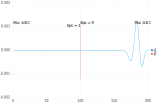

In [61]:
plot(1:size, fieldsnap)
plot!([100, 100], [-maximum(abs(fieldsnap)), maximum(abs(fieldsnap))])
plot!(ann=[(80, 0.8*maximum(abs(fieldsnap)), "Eps = 1")])
plot!(ann=[(100, 0.9*maximum(abs(fieldsnap)), "Eps = 9")])
plot!(ann=[(0, 0.9*maximum(abs(fieldsnap)), "Mur ABC")])
plot!(ann=[(180, 0.9*maximum(abs(fieldsnap)), "Mur ABC")])

In [46]:
print(fieldsum)

2.903557638071835e-5

# 3. Dielectric eps=9 with 5 Cell CPML
### Setup Grid

In [47]:
#Global parameters
size = 200;
endTime = 800;
num_snaps = 200;
snap_step = div(endTime, num_snaps);

eps1 = 9;
eps0 = 1;

#Grid

# Magnetic
hy = zeros(size);
mu = ones(size);

chyh = ones(size);
chye = ones(size);

# Electric
ez = zeros(size);
eps = ones(size);

cezh = ones(size);
ceze = ones(size);


for i in 1:99
    eps[i] = eps0;
end
for i in 100:size
    eps[i] = eps1;
end

# output params
ez_snapshot = Array{Any}(num_snaps);
hy_snapshot = Array{Any}(num_snaps);

# 
fieldsum = 1;
sumtime = 650;
fieldsnap = zeros(size);


### Setup CPML

In [48]:
#
# setup CPML
#

# constants
dx = 1.0;
R0 = 1e-5;
m = 2.85;
pml_width = 5.0;

# coeffs
sigma_max = -(m+1)*log(R0)/2/globals.imp0/(pml_width*dx)
sigma_x = zeros(size);
sigma_m_x = zeros(size);

for i in 1:round(Int,pml_width)
    sigma_x[i+1] = sigma_max * real(Complex(((pml_width-(i-1)-0.5)/pml_width))^m)
    sigma_m_x[i] = sigma_max * real(Complex(((pml_width-(i-1))/pml_width))^m)
    
    sigma_x[size-(i-1)] = sigma_max * real(Complex(((pml_width-i-0.5)/pml_width))^m)  
    sigma_m_x[size-(i-1)] = sigma_max * real(Complex(((pml_width-i)/pml_width))^m)
end

aex = exp(-sigma_x .* globals.imp0)-1
bex = exp(-sigma_x .* globals.imp0)

ahx = exp(-sigma_m_x .* globals.imp0)-1
bhx = exp(-sigma_m_x .* globals.imp0)

# arrays
p_hy = zeros(size);
p_ez = zeros(size);

### Run Simulation

In [49]:
for time in 1:endTime
    # Incident
    # ez_inc, hy_inc = sources.gaussian_source(50, time);
    delay = 150.
    width = 200.
    
    ez_inc = exp(-(time + 0.5 - (-0.5) - delay) * (time + 0.5 - (-0.5) - delay) / width);
    hy_inc = exp(-(time - delay) * (time - delay) / width);


    #
    # Magnetic
    #

    # CPML
    for i in 1:size-1
        p_hy[i] = bhx[i]*p_hy[i] + ahx[i]*(ez[i+1] - ez[i])
    end
           
    # Interior update
    for i = 1:size-1
        hy[i] = chyh[i] * hy[i] + chye[i] * (ez[i+1] - ez[i]) / globals.imp0 / mu[i]
    end
       
    # CPML
    for i in 1:size-1
        hy[i] += p_hy[i]/globals.imp0/mu[i]
    end

    # TFSF
    hy[49] -= hy_inc / globals.imp0 / mu[49]
    
    #
    # Electric
    #
    
    # CPML
    for i in 2:size
        p_ez[i] = bex[i]*p_ez[i] + aex[i]*(hy[i] - hy[i-1])
    end

    # Interior update
    for i = 2:size
        ez[i] = ceze[i] * ez[i] + cezh[i] * (hy[i] - hy[i-1]) * globals.imp0 / eps[i]
    end  
 
    # CPML
    for i in 2:size
        ez[i] += p_ez[i]*globals.imp0/eps[i]
    end
    # TFSF
    ez[50] += ez_inc / eps[50]


    #Catch minimum E-Field
    if time == sumtime
            fieldsum = sum(ez.^2)
            fieldsnap = copy(ez)
    end
    
    #Snapshots for animation
    if mod(time, snap_step) == 0
        ez_snapshot[div(time,snap_step)] = (time, copy(ez))
        hy_snapshot[div(time,snap_step)] = (time, copy(hy).*globals.imp0)        
    end
    
end
print(fieldsum)

0.00027295405799045684

### Plot animation

In [50]:
anim = Animation()

for i = 1:num_snaps
    p = plot(1:size, ez_snapshot[i][2], lab="Ez")
    plot!(1:size, hy_snapshot[i][2], lab="Hy*imp0")
    
    time = ez_snapshot[i][1]
    plot!(ann=[(150, 1.5, "time =$time")])
    plot!(ann=[(0, 1.1, "CPML")])
    
    plot!(ann=[(80, 1.2, "Eps = 1")])
    plot!(ann=[(101, 1.1, "Eps = 9")])    
    plot!([100, 100], [-2, 2])
    
    plot!(ann=[(180, 1.1, "CPML")])
    
    plot!(xlims=(1, 200), ylims=(-2, 2))
    frame(anim, p)
end
gif(anim, "./Task1/ABC-5-CPML.gif", fps=15)

INFO: Saved animation to /media/storage/Documents/Github/1d-fdtd/tasks/Task1/ABC-5-CPML.gif


Plots.AnimatedGif("/media/storage/Documents/Github/1d-fdtd/tasks/Task1/ABC-5-CPML.gif")

### Field after reflection

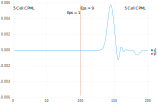

In [51]:
plot(1:size, fieldsnap)
plot!([100, 100], [-maximum(abs(fieldsnap)), maximum(abs(fieldsnap))])
plot!(ann=[(80, 0.8*maximum(abs(fieldsnap)), "Eps = 1")])
plot!(ann=[(100, 0.9*maximum(abs(fieldsnap)), "Eps = 9")])
plot!(ann=[(0, 0.9*maximum(abs(fieldsnap)), "5 Cell CPML")])
plot!(ann=[(165, 0.9*maximum(abs(fieldsnap)), "5 Cell CPML")])

In [52]:
print(fieldsum)

0.00027295405799045684

# 4. Dielectric eps=9 with 20 Cell CPML
### Setup Grid

In [53]:
#Global parameters
size = 200;
endTime = 800;
num_snaps = 200;
snap_step = div(endTime, num_snaps);

eps1 = 9;
eps0 = 1;

#Grid

# Magnetic
hy = zeros(size);
mu = ones(size);

chyh = ones(size);
chye = ones(size);

# Electric
ez = zeros(size);
eps = ones(size);

cezh = ones(size);
ceze = ones(size);


for i in 1:99
    eps[i] = eps0;
end
for i in 100:size
    eps[i] = eps1;
end

# output params
ez_snapshot = Array{Any}(num_snaps);
hy_snapshot = Array{Any}(num_snaps);

# 
fieldsum = 1;
sumtime = 650;
fieldsnap = zeros(size);


### Setup CPML

In [54]:
#
# setup CPML
#

# constants
dx = 1.0;
R0 = 1e-5;
m = 2.85;
pml_width = 20.0;

# coeffs
sigma_max = -(m+1)*log(R0)/2/globals.imp0/(pml_width*dx)
sigma_x = zeros(size);
sigma_m_x = zeros(size);

for i in 1:round(Int,pml_width)
    sigma_x[i+1] = sigma_max * real(Complex(((pml_width-(i-1)-0.5)/pml_width))^m)
    sigma_m_x[i] = sigma_max * real(Complex(((pml_width-(i-1))/pml_width))^m)
    
    sigma_x[size-(i-1)] = sigma_max * real(Complex(((pml_width-(i)-0.5)/pml_width))^m)  
    sigma_m_x[size-(i-1)] = sigma_max * real(Complex(((pml_width-(i))/pml_width))^m)
end

aex = exp(-sigma_x .* globals.imp0)-1
bex = exp(-sigma_x .* globals.imp0)

ahx = exp(-sigma_m_x .* globals.imp0)-1
bhx = exp(-sigma_m_x .* globals.imp0)

# arrays
p_hy = zeros(size);
p_ez = zeros(size);

### Run Simulation

In [55]:
for time in 1:endTime
    # Incident
    # ez_inc, hy_inc = sources.gaussian_source(50, time);
    delay = 150.
    width = 200.
    
    ez_inc = exp(-(time + 0.5 - (-0.5) - delay) * (time + 0.5 - (-0.5) - delay) / width);
    hy_inc = exp(-(time - delay) * (time - delay) / width);


    #
    # Magnetic
    #

    # CPML
    for i in 1:size-1
        p_hy[i] = bhx[i]*p_hy[i] + ahx[i]*(ez[i+1] - ez[i])
    end
           
    # Interior update
    for i = 1:size-1
        hy[i] = chyh[i] * hy[i] + chye[i] * (ez[i+1] - ez[i]) / globals.imp0 / mu[i]
    end
       
    # CPML
    for i in 1:size-1
        hy[i] += p_hy[i]/globals.imp0/mu[i]
    end

    # TFSF
    hy[49] -= hy_inc / globals.imp0 / mu[49]
    
    #
    # Electric
    #
    
    # CPML
    for i in 2:size
        p_ez[i] = bex[i]*p_ez[i] + aex[i]*(hy[i] - hy[i-1])
    end

    # Interior update
    for i = 2:size
        ez[i] = ceze[i] * ez[i] + cezh[i] * (hy[i] - hy[i-1]) * globals.imp0 / eps[i]
    end  
 
    # CPML
    for i in 2:size
        ez[i] += p_ez[i]*globals.imp0/eps[i]
    end
    # TFSF
    ez[50] += ez_inc / eps[50]


    #Catch minimum E-Field
    if time == sumtime
            fieldsum = sum(ez.^2)
            fieldsnap = copy(ez)
    end
    
    #Snapshots for animation
    if mod(time, snap_step) == 0
        ez_snapshot[div(time,snap_step)] = (time, copy(ez))
        hy_snapshot[div(time,snap_step)] = (time, copy(hy).*globals.imp0)        
    end
    
end
print(fieldsum)

3.1173442697269598e-9

### Plot animation

In [56]:
anim = Animation()

for i = 1:num_snaps
    p = plot(1:size, ez_snapshot[i][2], lab="Ez")
    plot!(1:size, hy_snapshot[i][2], lab="Hy*imp0")
    
    time = ez_snapshot[i][1]
    plot!(ann=[(150, 1.5, "time =$time")])
    plot!(ann=[(0, 1.1, "CPML")])
    
    plot!(ann=[(80, 1.2, "Eps = 1")])
    plot!(ann=[(101, 1.1, "Eps = 9")])    
    plot!([100, 100], [-2, 2])
    
    plot!(ann=[(180, 1.1, "CPML")])
    
    plot!(xlims=(1, 200), ylims=(-2, 2))
    frame(anim, p)
end
gif(anim, "./Task1/ABC-20-CPML.gif", fps=15)

INFO: Saved animation to /media/storage/Documents/Github/1d-fdtd/tasks/Task1/ABC-20-CPML.gif


Plots.AnimatedGif("/media/storage/Documents/Github/1d-fdtd/tasks/Task1/ABC-20-CPML.gif")

### Field after reflection

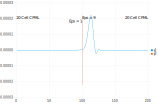

In [57]:
plot(1:size, fieldsnap)
plot!([100, 100], [-maximum(abs(fieldsnap)), maximum(abs(fieldsnap))])
plot!(ann=[(80, 0.8*maximum(abs(fieldsnap)), "Eps = 1")])
plot!(ann=[(100, 0.9*maximum(abs(fieldsnap)), "Eps = 9")])
plot!(ann=[(0, 0.9*maximum(abs(fieldsnap)), "20 Cell CPML")])
plot!(ann=[(165, 0.9*maximum(abs(fieldsnap)), "20 Cell CPML")])

In [58]:
print(fieldsum)

3.1173442697269598e-9